In [1]:
import pymolpro as pmp
import math 
import numpy as np


def orbitalsize(orbital):
    tmp=orbital.second_moment_eigenvalues
    tmp=tmp.tolist()
    tmp=[float(i) for i in tmp]
    tmp.append(math.sqrt(sum([orbital.local_second_moments[i][i] for i in range(3)])))
    return np.array(tmp)

def chkorbid(o1,o2):
    if o1.startswith('-'):
        chko1=o1[1:]
    else:
        chko1=o1
    if o2.startswith('-'):
        chko2=o2[1:]
    else:
        chko2=o2
    if chko1==chko2:
        return True
    else: 
        return False

In [2]:
geo_list=['He','Ne','Ar','Kr']
p_list=[]

In [3]:
for i in geo_list:
    p=pmp.Project(i)
    p.write_input(f"""
    geometry={{{i}}}
    basis, cc-pv5z;
    rhf;
    locali, pipek;
    CCSD;
    put,xml
    """
                  )
    p.run(wait=True)
    p_list.append(p)
    print(i, "done")

He done
Ne done
Ar done
Kr done


In [4]:
pair_list=[]
test_dens_list=[]
train_arr_list=[]
arr_list=[]
test_arr_list=[]
test_corr_list=[]
for p in p_list:
    orbital_dt={}
    dens_dt={}
    if p.name=='Ar':
        for orbital in p.orbitals():
            points=orbital.grid(4)
            values=orbital.evaluate(points,values=True)
            dens_dt.update({f'{orbital.ID}':values})
            dens_dt.update({f'-{orbital.ID}':values})
        for pair in p.xpath("//pair"):
            tmp=pmp.element_to_dict(pair)
            oid1,oid2=tmp['orbital1'],tmp['orbital2']
            if chkorbid(oid1,oid2)==True:
                tmp_arr=np.array([dens_dt[oid1]])
                test_arr_list.append(tmp_arr)
                test_corr_list.append(float(tmp['energy']))

    else:
        for orbital in p.orbitals():
            points=orbital.grid(4)
            values=orbital.evaluate(points,values=True)
            dens_dt.update({f'{orbital.ID}':values})
            dens_dt.update({f'-{orbital.ID}':values})
        for pair in p.xpath("//pair"):
            tmp=pmp.element_to_dict(pair)
            oid1,oid2=tmp['orbital1'],tmp['orbital2']
            if chkorbid(oid1,oid2)==True:
                tmp_arr=np.array([dens_dt[oid1]])
                train_arr_list.append(tmp_arr)
                pair_list.append(float(tmp['energy']))
                    
labels=np.array(pair_list)
features=np.stack(train_arr_list)
test_arr=np.stack(test_arr_list)
test_labels=np.stack(test_corr_list)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - loss: 2.3221e-04 - mae: 0.0118 - mape: 92.0485  
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 7.5771e-05 - mae: 0.0073 - mape: 88.6484
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 1.3146e-05 - mae: 0.0024 - mape: 20.4461
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 1.2317e-05 - mae: 0.0025 - mape: 34.1461
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 3.8718e-06 - mae: 0.0016 - mape: 21.0373
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 1.1506e-06 - mae: 8.0473e-04 - mape: 8.0894
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 5.3978e-07 - mae: 6.0513e-04 - mape: 5.8081
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 2.5978e-07 - mae: 4.7055e-04 - mape: 5.0671
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 1.8191e-07 - mae: 3.8401e-04 - mape: 4.4089
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.7018e-07 - mae

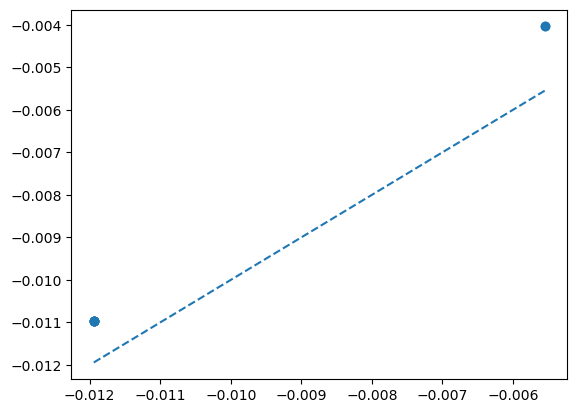

In [9]:
import keras
import tensorflow as tf

dataset=tf.data.Dataset.from_tensor_slices((features,labels))
dataset = dataset.shuffle(buffer_size=len(pair_list)//4).batch(batch_size=1)


model=keras.Sequential([
    keras.layers.Input(shape=(1,64)),
    keras.layers.Dense(192, activation='softmax'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mse',
             metrics=['mae','mape'])
model.fit(dataset,epochs=50)

predictions=model.predict(test_arr)

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.scatter(test_labels,predictions)
plt.plot((min(test_labels),max(test_labels)),(min(test_labels),max(test_labels)),linestyle='--')

In [ ]:
print(predictions)

In [ ]:
print(test_arr_list)

In [ ]:

def buildmodel(act,loss):
    model=keras.Sequential([
        keras.layers.Input(shape=(72,)),
        keras.layers.Dense(64,activation=act),
        keras.layers.Dense(1,)
    ])
    model.compile(
        'Adam',
        loss=loss)
    return model

act_funcs=['relu','selu','tanh','sigmoid','gelu','softmax']
loss=['mse','mae','mape','huber']

result_dt=[]

q=0
for i in act_funcs:
    for j in loss:
        model=buildmodel(i,j)
        model.fit(dataset,epochs=25)
        tmp=np.array(model.predict(test_arr))
        result_dt.append({'params':{i,j},'predictions':tmp})


In [ ]:
for i,results in enumerate(result_dt):
    plt.figure(i)
    plt.scatter(test_labels, results['predictions'], label=f"Predictions - {results['params']}")
    plt.title(f"Predictions for Hyperparameters: {results['params']}")
    plt.plot((min(labels),max(labels)),(min(labels),max(labels)),linestyle='--')
    plt.xlabel("true value")
    plt.ylabel("Prediction Value")
    plt.legend()
    plt.show()
    

In [ ]:
from sklearn.metrics import mean_squared_error
def buildmodel(units):
    model=keras.Sequential([
        keras.layers.Input(shape=(72,)),
        keras.layers.Dense(units,activation='softmax'),
        keras.layers.Dense(1,)
    ])
    model.compile(
        'Adam',
        loss='huber')
    return model

mse_list=[]
for i in range(36,720,36):
    model=buildmodel(i)
    model.fit(dataset,epochs=30)
    tmp=np.array(model.predict(test_arr))
    result_dt.append({'params':{i,j},'predictions':tmp})
    mse_list.append({'units':i,'mse':mean_squared_error(tmp,test_labels)})
    
    

In [ ]:
units=[entry['units'] for entry in mse_list]
mse=[entry['mse'] for entry in mse_list]
plt.plot(units,mse)
plt.show()

In [ ]:
model=keras.Sequential([
    keras.layers.Input(shape=(72,)),
    keras.layers.Dense(216,activation='softmax'),
    keras.layers.Dense(1,)
])
model.compile(
'Adam',
loss='huber')
model.fit(dataset,epochs=50)
tmp=model.predict(test_arr)
plt.scatter(test_labels,tmp)
plt.plot((min(test_labels),max(test_labels)),(min(test_labels),max(test_labels)),linestyle='--')
plt.xlabel("true value")
plt.ylabel("Prediction Value")
plt.show()

In [ ]:
def buildmodel(depth,acti):
    model=keras.Sequential()
    model.add(keras.layers.Input(shape=(72,)))
    model.add(keras.layers.Dense(216,activation='softmax'))
    for i in range(depth):
        model.add(keras.layers.Dense(99,activation=acti))
    model.add(keras.layers.Dense(1,))
    model.compile(
        'Adam',
        loss='huber')
    return model
actis=['tanh','sigmoid','relu','gelu']
depth_list=[i for i in range(10)]

tanhr_list=[]
sigmoidr_list=[]
relur_list=[]
gelur_list=[]

for i in depth_list:
    for j in actis:
        model=buildmodel(i,j)
        model.fit(dataset,epochs=30)
        tmp=np.array(model.predict(test_arr))
        if j=='tanh':
            tanhr_list.append({'depth':i,'mse':mean_squared_error(test_labels,tmp)})
        elif j=='relu':
           relur_list.append({'depth':i,'mse':mean_squared_error(test_labels,tmp)})
        elif j=='sigmoid':
            sigmoidr_list.append({'depth':i,'mse':mean_squared_error(test_labels,tmp)})
        elif j=='gelu':
            gelur_list.append({'depth':i,'mse':mean_squared_error(test_labels,tmp)})
        

In [ ]:
tanh_list=[i['mse'] for i in tanhr_list]
sigmoid_list=[i['mse'] for i in sigmoidr_list]
relu_list=[i['mse'] for i in relur_list]
gelu_list=[i['mse'] for i in gelur_list]


plt.plot(depth_list,tanh_list,c='red',label='tanh')
plt.plot(depth_list,sigmoid_list,c='blue',label='sigmoid')
plt.plot(depth_list,relu_list,c='yellow',label='relu')
plt.plot(depth_list,gelu_list,c='black',label='gelu')
plt.ylabel('Mean Squared Error')
plt.xlabel('Depth')
plt.legend()
plt.savefig('Depth_softmax.png')
plt.show()





In [ ]:

model=keras.Sequential([
    keras.layers.Input(shape=(72,)),
    keras.layers.Dense(216, activation='softmax'),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='huber',
             metrics=['mae','mape'])
model.fit(dataset,epochs=50)

predictions=model.predict(test_arr)
plt.scatter(test_labels,predictions)
plt.plot((min(test_labels),max(test_labels)),(min(test_labels),max(test_labels)), linestyle='--')
plt.xlabel('True Values')
plt.ylabel('ML predictions')
plt.show()